# The Battle of Neighbourhoods

There are various ways of expanding a business, and companies can choose different growth strategies to reach their goal. But one common strategy is targeting new customers in new locations for the existing products. The following project takes into consideration the neighbourhoods of a city, and finds the similarity between them in order to develop insights for businesses to choose the right new  market for their product.

In this particular case, we try to find the best match to Maple Leaf neighbourhood in the city of Toronto to open another branch of a successfully running Chinese resaurant in Maple Leaf. This would be done by finding neighbourhoods that are most similar to Maple Leaf with respect to the venues distribution across these neighbourhoods and then using the demographic and  income data of each neighbourhood to get the top ten list.

We get our data from the following resources:  

1. Geospatial data - neighbourhood names and their geographical coordinates.  
Source - https://open.toronto.ca/dataset/neighbourhoods/  
  
2. Venues data - list of venues and their categories for each neighbourhood.  
Source - Foursquare API  
  
3. Demographic and Income data - total population, population of people with Chinese origin, and the median household income in each neighbourhood.  
Sources - https://open.toronto.ca/dataset/wellbeing-toronto-demographics/, https://open.toronto.ca/dataset/wellbeing-toronto-demographics-nhs-indicators/

### Importing libraries

Let us start by importing all the libraries we would need for this project.

In [1]:
# library to handle data in a vectorized manner
import numpy as np

# library for data analsysis
import pandas as pd

# adjusting column and row width
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# library to handle requests
import requests

# library to handle JSON files
import json

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# map rendering library
!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                       

### Loading data

Now we load our data from different resources into our required dataframes and then prepare them into our required formats.

In [2]:
# geospatial data
toronto_geo = "https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15?format=csv&projection=4326"
df_geo = pd.read_csv(toronto_geo)
df_geo.rename(columns={"AREA_NAME":"Neighbourhood(code)", "AREA_SHORT_CODE":"Neighbourhood Id", "LATITUDE":"Latitude", "LONGITUDE":"Longitude"}, inplace = True) 
df_geo_data = df_geo[['Neighbourhood(code)', 'Neighbourhood Id', 'Latitude', 'Longitude']]

# demographic data
toronto_demo = "https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/335e3407-d3ca-422a-bfac-e3807cfbe0d5"
df_demo = pd.read_excel(toronto_demo, sheet_name = 'RawData-Ref Period 2011', skiprows = range(1))
df_demo_data = df_demo[['Neighbourhood','Neighbourhood Id','Total Population']]

# income data
toronto_income = "https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/8d838d5c-20da-48bd-b4a7-3e66b1c25b55"
df_income =pd.read_excel(toronto_income)
df_income.rename(columns={"Hood#":"Neighbourhood Id", "    Chinese":"Chinese Origin", "  Median household total income $":"Median household income($)"}, inplace = True)
df_income_data = df_income[['Neighbourhood Id', 'Chinese Origin', 'Median household income($)']]

# merging all the data into one dataframe
data_merge1 = pd.merge(df_demo_data, df_income_data, on = 'Neighbourhood Id')
data_merge2 = pd.merge(data_merge1, df_geo_data[['Neighbourhood Id', 'Latitude', 'Longitude']], on = 'Neighbourhood Id')

toronto_data = data_merge2[['Neighbourhood', 'Total Population', 'Chinese Origin', 'Median household income($)', 'Latitude', 'Longitude']]

Let us look at the final datafame that we created.

In [3]:
print(toronto_data.shape)
toronto_data.head()

(140, 6)


,Neighbourhood,Total Population,Chinese Origin,Median household income($),Latitude,Longitude
0,West Humber-Clairville,34100,695,66241,43.716180,-79.596356
1,Mount Olive-Silverstone-Jamestown,32790,200,49934,43.746868,-79.587259
2,Thistletown-Beaumond Heights,10140,105,62042,43.737988,-79.563491
3,Rexdale-Kipling,10485,200,56545,43.723725,-79.566228
4,Elms-Old Rexdale,9550,120,50846,43.721519,-79.548983


So, here we have a dataframe with 140 neighbourhoods of the city of Toronto with their respective population, population with Chinese origin, median household income and the geographiical coordinates.

### Creating a map of Toronto

Now we create a map of the city of Toronto and add markers to our map by using the coordinates of the neighbourhoods.

In [4]:
# Create a map of Toronto

address = 'Toronto, ON'
geolocator = Nominatim(user_agent="toronto_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Coordinates of Toronto: ', latitude, longitude)

toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)

Coordinates of Toronto:  43.6534817 -79.3839347


In [5]:
# add markers to map

for lat, lng, Neighbourhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood']):
    label = '{}'.format(Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        parse_html=False).add_to(toronto_map)

toronto_map

### Define Foursquare Credentials and Version

We now define our Foursquare credentials and version to use it for 'explore' endpoint calls to the API.

In [7]:
# The code was removed by Watson Studio for sharing.

### Exploring Neighbourhoods in Toronto

Let's now create a custom function (borrowed from the Foursquare lab of the course) to request top 100 venues for each neighbourhood within a radius of 500 meters.

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we write the code to run the above function on each neighbourhood and create a new dataframe called toronto_venues.

In [9]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

West Humber-Clairville
Mount Olive-Silverstone-Jamestown
Thistletown-Beaumond Heights
Rexdale-Kipling
Elms-Old Rexdale
Kingsview Village-The Westway
Willowridge-Martingrove-Richview
Humber Heights-Westmount
Edenbridge-Humber Valley
Princess-Rosethorn
Eringate-Centennial-West Deane
Markland Wood
Etobicoke West Mall
Islington-City Centre West
Kingsway South
Stonegate-Queensway
Mimico
New Toronto
Long Branch
Alderwood
Humber Summit
Humbermede
Pelmo Park-Humberlea
Black Creek
Glenfield-Jane Heights
Downsview-Roding-CFB
York University Heights
Rustic
Maple Leaf
Brookhaven-Amesbury
Yorkdale-Glen Park
Englemount-Lawrence
Clanton Park
Bathurst Manor
Westminster-Branson
Newtonbrook West
Willowdale West
Lansing-Westgate
Bedford Park-Nortown
St.Andrew-Windfields
Bridle Path-Sunnybrook-York Mills
Banbury-Don Mills
Victoria Village
Flemingdon Park
Parkwoods-Donalda
Pleasant View
Don Valley Village
Hillcrest Village
Bayview Woods-Steeles
Newtonbrook East
Willowdale East
Bayview Village
Henry Farm
O'

Let's check the size of the resulting dataframe and top 5 entries.

In [10]:
print(toronto_venues.shape)
toronto_venues.head()

(2050, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,West Humber-Clairville,43.71618,-79.596356,Tim Hortons,43.714657,-79.593716,Coffee Shop
1,West Humber-Clairville,43.71618,-79.596356,Mandarin Buffet,43.720360,-79.594387,Chinese Restaurant
2,West Humber-Clairville,43.71618,-79.596356,Xawaash,43.715786,-79.593053,Mediterranean Restaurant
3,West Humber-Clairville,43.71618,-79.596356,Staples Rexdale,43.718539,-79.594570,Paper / Office Supplies Store
4,West Humber-Clairville,43.71618,-79.596356,Winners,43.719819,-79.594923,Department Store


Let's check how many venues were returned for each neighbourhood.

In [11]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt North,18,18,18,18,18,18
Agincourt South-Malvern West,19,19,19,19,19,19
Alderwood,5,5,5,5,5,5
Annex,26,26,26,26,26,26
Banbury-Don Mills,24,24,24,24,24,24
Bathurst Manor,4,4,4,4,4,4
Bay Street Corridor,67,67,67,67,67,67
Bayview Village,3,3,3,3,3,3
Bayview Woods-Steeles,4,4,4,4,4,4


Let's also find out how many unique categories can be curated from all the returned venues.

In [12]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 278 uniques categories.


### Analysing Each Neighbourhood

In [13]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Neighbourhood,African Restaurant,Airport Service,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Quad,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Night Market,Nightclub,Nightlife Spot,Noodle House,North Indian Restaurant,Optical Shop,Organic Grocery,Other Great Outdoors,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Transportation Service,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,W

And let's examine the new dataframe size.

In [14]:
toronto_onehot.shape

(2050, 279)

Next, let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category.

In [16]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped

(138, 279)


,Neighbourhood,African Restaurant,Airport Service,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Quad,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Night Market,Nightclub,Nightlife Spot,Noodle House,North Indian Restaurant,Optical Shop,Organic Grocery,Other Great Outdoors,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Transportation Service,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,W

So, we have 138 neighbourhoods in this dataframe, which means the API did not return any venue for 2 neighbourhoods.

### Now let's create a new dataframe that displays top 10 venues for each neighborhood.

In [17]:
# First, let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
import numpy as np # library to handle data in a vectorized manner
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Chinese Restaurant,Clothing Store,Fast Food Restaurant,Pizza Place,Fried Chicken Joint,Frozen Yogurt Shop,Liquor Store,Beer Store,Sandwich Place,Bank
1,Agincourt South-Malvern West,Chinese Restaurant,Pizza Place,BBQ Joint,Cantonese Restaurant,Mediterranean Restaurant,Filipino Restaurant,Pool Hall,Bank,Restaurant,Café
2,Alderwood,Pizza Place,Convenience Store,Pharmacy,Coffee Shop,Farm,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
3,Annex,Café,Sandwich Place,Pub,Coffee Shop,Convenience Store,Middle Eastern Restaurant,Metro Station,Pharmacy,Liquor Store,French Restaurant
4,Banbury-Don Mills,Coffee Shop,Women's Store,Pizza Place,Cantonese Restaurant,Kids Store,Sandwich Place,Liquor Store,Chocolate Shop,Bank,Italian Restaurant


### Clustering Neighborhoods

Let us first try to find the optimum k for k-means clustering.

First we try the Elbow method.

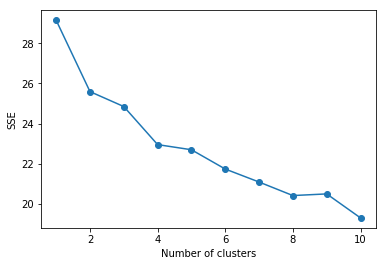

In [18]:
toronto_clustering = toronto_grouped.drop('Neighbourhood', 1)

sse = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(toronto_clustering)
    sse.append(km.inertia_)

# plot
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

The Elbow method tells us that the optimum value for k is 4. But to be more certain, we can perform Silhouette method in combination to validate our k value.

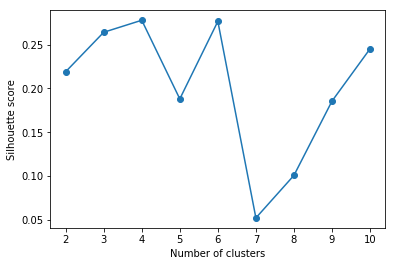

In [19]:
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(toronto_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(toronto_clustering, labels, metric = 'euclidean'))
        
    
# plot
plt.plot(range(2, 11), sil, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

From the above graph it is clear that the optimum value for k is 4 as the peak of silhouette score occurs at k = 4.

Now let us run k-means to cluster the neighborhoods into 4 clusters.

In [21]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32)

Let's create a new dataframe that includes the cluster label as well as the top 10 venues for each neighborhood.

In [22]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

# check the last columns!
toronto_merged

,Neighbourhood,Total Population,Chinese Origin,Median household income($),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Humber-Clairville,34100,695,66241,43.716180,-79.596356,0.0,Department Store,Hotel,Bank,Chinese Restaurant,Paper / Office Supplies Store,Swiss Restaurant,Coffee Shop,Gym / Fitness Center,Mediterranean Restaurant,Pizza Place
1,Mount Olive-Silverstone-Jamestown,32790,200,49934,43.746868,-79.587259,1.0,Japanese Restaurant,Park,Coffee Shop,Zoo Exhibit,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
2,Thistletown-Beaumond Heights,10140,105,62042,43.737988,-79.563491,0.0,Indian Restaurant,Caribbean Restaurant,Bank,Spa,Thai Restaurant,Supermarket,Asian Restaurant,Dance Studio,Coffee Shop,Ice Cream Shop
3,Rexdale-Kipling,10485,200,56545,43.723725,-79.566228,0.0,Flower Shop,Jewelry Store,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm
4,Elms-Old Rexdale,9550,120,50846,43.721519,-79.548983,0.0,African Restaurant,Pool,Business Service,Mobile Phone Shop,Construction & Landscaping,History Museum,Hockey Arena,Filipino Restaurant,Field,Fast Food Restaurant
5,Kingsview Village-The Westway,21725,450,55454,43.698993,-79.547863,0.0,Coffee Shop,Pizza Place,Grocery Store,Zoo Exhibit,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant
6,Willowridge-Martingrove-Richview,21345,460,63701,43.683645,-79.554221,3.0,Gym,Zoo Exhibit,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm
7,Humber Heights-Westmount,10580,105,60410,43.692233,-79.522416,0.0,Furniture / Home Store,Gas Station,Pizza Place,Park,Zoo Exhibit,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
8,Edenbridge-Humber Valley,14945,265,71646,43.670886,-79.522458,1.0,Park,Indian Restaurant,Fast Food Restaurant,Zoo Exhibit,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
9,Princess-Rosethorn,11200,330,114844,43.666051,-79.544559,2.0,Playground,Zoo Exhibit,Farm,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market


Changing the Cluster Labels back to type int from type float and removing rows with no venues data . (Newtonbrook West, ST.Andrew-Windfields)

In [23]:
toronto_merged.dropna(subset=["Cluster Labels"], axis = 0, inplace = True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

Finally, let's visualize the resulting clusters.

In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

**Cluster 1**

In [25]:
Cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(6, toronto_merged.shape[1]))]]
print(Cluster1.shape)
Cluster1

(117, 12)


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Humber-Clairville,0,Department Store,Hotel,Bank,Chinese Restaurant,Paper / Office Supplies Store,Swiss Restaurant,Coffee Shop,Gym / Fitness Center,Mediterranean Restaurant,Pizza Place
2,Thistletown-Beaumond Heights,0,Indian Restaurant,Caribbean Restaurant,Bank,Spa,Thai Restaurant,Supermarket,Asian Restaurant,Dance Studio,Coffee Shop,Ice Cream Shop
3,Rexdale-Kipling,0,Flower Shop,Jewelry Store,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm
4,Elms-Old Rexdale,0,African Restaurant,Pool,Business Service,Mobile Phone Shop,Construction & Landscaping,History Museum,Hockey Arena,Filipino Restaurant,Field,Fast Food Restaurant
5,Kingsview Village-The Westway,0,Coffee Shop,Pizza Place,Grocery Store,Zoo Exhibit,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant
7,Humber Heights-Westmount,0,Furniture / Home Store,Gas Station,Pizza Place,Park,Zoo Exhibit,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
10,Eringate-Centennial-West Deane,0,Convenience Store,Pizza Place,Chinese Restaurant,Park,Coffee Shop,Hockey Arena,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market
11,Markland Wood,0,Discount Store,Pizza Place,Fast Food Restaurant,Bank,Zoo Exhibit,Event Space,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant
12,Etobicoke West Mall,0,Skating Rink,Transportation Service,Coffee Shop,Farmers Market,Zoo Exhibit,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
13,Islington-City Centre West,0,Sandwich Place,Fast Food Restaurant,Pizza Place,Turkish Restaurant,Café,Fried Chicken Joint,Garden Center,Thai Restaurant,Bank,Rental Car Location


**Cluster2**

In [26]:
Cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(6, toronto_merged.shape[1]))]]
print(Cluster2.shape)
Cluster2

(18, 12)


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Mount Olive-Silverstone-Jamestown,1,Japanese Restaurant,Park,Coffee Shop,Zoo Exhibit,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
8,Edenbridge-Humber Valley,1,Park,Indian Restaurant,Fast Food Restaurant,Zoo Exhibit,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
14,Kingsway South,1,Pool,Park,Dog Run,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
24,Glenfield-Jane Heights,1,Park,Pool,Tea Room,Moving Target,Event Space,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant
25,Downsview-Roding-CFB,1,Moving Target,Business Service,Park,Zoo Exhibit,Falafel Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farm
29,Brookhaven-Amesbury,1,Park,Zoo Exhibit,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farm,Donut Shop
32,Clanton Park,1,Home Service,Park,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farm,Donut Shop
36,Willowdale West,1,Mobile Phone Shop,Park,Zoo Exhibit,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farm
37,Lansing-Westgate,1,Park,Zoo Exhibit,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farm,Donut Shop
44,Parkwoods-Donalda,1,Food & Drink Shop,Park,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farm,Donut Shop


**Cluster3**

In [27]:
Cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(6, toronto_merged.shape[1]))]]
print(Cluster3.shape)
Cluster3

(2, 12)


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Princess-Rosethorn,2,Playground,Zoo Exhibit,Farm,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market
100,Forest Hill South,2,Playground,Zoo Exhibit,Farm,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market


**Cluster4**

In [28]:
Cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + list(range(6, toronto_merged.shape[1]))]]
print(Cluster4.shape)
Cluster4

(1, 12)


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Willowridge-Martingrove-Richview,3,Gym,Zoo Exhibit,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm


Let us find our target cluster that contains the neighbourhood, Maple Leaf.

In [29]:
target_cluster_df = toronto_merged.loc[toronto_merged['Neighbourhood']=='Maple Leaf']
target_cluster_df.reset_index(inplace=True)
target_cluster=target_cluster_df.loc[0].at['Cluster Labels']
print('The target cluster is: {} '.format(target_cluster + 1))

The target cluster is: 1 


**Let us prepare a dataframe that gives us the top 10 neighbourhoods for opening our Chinese restaurant.**

In order to that, we first create a dataframe with normalised values of total population, population with Chinese origin and the median household income, so as to use it for creating a ranking of the neighbourhoods.

In [32]:
df_norm = toronto_data[['Neighbourhood', 'Total Population', 'Chinese Origin', 'Median household income($)']].copy()

df_norm.loc[:, 'Total Population'] = df_norm.loc[:, 'Total Population']/df_norm['Total Population'].max()
df_norm.loc[:, 'Chinese Origin'] = df_norm.loc[:, 'Chinese Origin']/df_norm['Chinese Origin'].max()
df_norm.loc[:, 'Median household income($)'] = df_norm.loc[:, 'Median household income($)']/df_norm['Median household income($)'].max()

df_norm.rename(columns={"Total Population":"Population Normalised", "Chinese Origin":"Chinese Normalised", "Median household income($)":"Income Normalised"}, inplace = True)

Let us now merge the above dataframe with Cluster 1 dataframe and generate the top 10 recommended neighbourhoods for our project.

In [33]:
possible_neighbourhoods = Cluster1.merge(df_norm[['Neighbourhood', 'Population Normalised', 'Chinese Normalised', 'Income Normalised']], on='Neighbourhood')
possible_neighbourhoods['Ranking'] = possible_neighbourhoods['Population Normalised'] * 0.5 + possible_neighbourhoods['Chinese Normalised'] * 0.3 + possible_neighbourhoods['Income Normalised'] * 0.2

recommended_neighbourhoods = possible_neighbourhoods.sort_values(by = 'Ranking', ascending = False).head(10)
recommended_neighbourhoods.reset_index(inplace = True, drop = True)

So, our final list of top 10 recommended neighbourhoods is:

In [34]:
recommended_neighbourhoods

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population Normalised,Chinese Normalised,Income Normalised,Ranking
0,L'Amoreaux,0,Chinese Restaurant,Pizza Place,Bank,Gym Pool,Sandwich Place,Thrift / Vintage Store,Bakery,Nail Salon,Camera Store,Coffee Shop,0.841893,0.913272,0.257071,0.746342
1,Willowdale East,0,Hotel,Dumpling Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Field,Fast Food Restaurant,Food & Drink Shop,Farm,0.843955,0.79939,0.308433,0.723481
2,Woburn,0,Indian Restaurant,Bakery,American Restaurant,Farm,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,1.000000,0.227487,0.249279,0.618102
3,Agincourt North,0,Chinese Restaurant,Clothing Store,Fast Food Restaurant,Pizza Place,Fried Chicken Joint,Frozen Yogurt Shop,Liquor Store,Beer Store,Sandwich Place,Bank,0.567573,0.922139,0.288306,0.618089
4,Steeles,0,Chinese Restaurant,Sushi Restaurant,Pizza Place,BBQ Joint,Shopping Mall,Vietnamese Restaurant,Korean Restaurant,Supermarket,Fast Food Restaurant,Pharmacy,0.468791,0.965364,0.292063,0.582417
5,Waterfront Communities-The Island,0,Boat or Ferry,Zoo Exhibit,Farmers Market,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant,0.812840,0.281241,0.331172,0.557027
6,Rouge,0,Zoo Exhibit,Zoo,Tram Station,Dessert Shop,Restaurant,Other Great Outdoors,Fast Food Restaurant,Gift Shop,Food & Drink Shop,Hardware Store,0.860450,0.111665,0.390815,0.541888
7,Malvern,0,Fast Food Restaurant,Sandwich Place,Bubble Tea Shop,Pizza Place,Pharmacy,Gym / Fitness Center,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,0.845080,0.188418,0.275684,0.534202
8,Tam O'Shanter-Sullivan,0,Pizza Place,Pharmacy,Italian Restaurant,Rental Car Location,Chinese Restaurant,Noodle House,Bus Stop,Fast Food Restaurant,Convenience Store,Fried Chicken Joint,0.513402,0.523691,0.238266,0.461462
9,Islington-City Centre West,0,Sandwich Place,Fast Food Restaurant,Pizza Place,Turkish Restaurant,Café,Fried Chicken Joint,Garden Center,Thai Restaurant,Bank,Rental Car Location,0.713590,0.06844,0.318856,0.441098


This notebook was created by Navpreet Sharma as part of the IBM Applied Data Science Capstone course project of Coursera. Thank you for your time.